In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from yellowbrick.cluster import KElbowVisualizer



# Data analysis and preparation

In [7]:
df = pd.read_csv("weather_classification_data.csv")


In [26]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  int64  
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  int64  
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  int64  
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(5), object(1)
memory usage: 1.1+ MB
None


**Working with duplicates** 

In [6]:
# Показать дубликаты
print(df[df.duplicated(keep=False)])

# Проверка наличия дубликатов
duplicates_exist = df.duplicated().any()
print(f"Есть ли дубликаты в DataFrame: {duplicates_exist}")

# Подсчет количества дубликатов
num_duplicates = df.duplicated().sum()
print(f"Количество дубликатов: {num_duplicates}")

Empty DataFrame
Columns: [Temperature, Humidity, Wind Speed, Precipitation (%), Cloud Cover, Atmospheric Pressure, UV Index, Season, Visibility (km), Location, Weather Type]
Index: []
Есть ли дубликаты в DataFrame: False
Количество дубликатов: 0


**Processing columns that contain the value "object"**

In [8]:
print(df.dtypes)
print(df.shape)
df.head()

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
Weather Type             object
dtype: object
(13200, 11)


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [9]:
print(df["Cloud Cover"].unique())
print(df["Season"].unique())
print(df["Location"].unique())
print(df["Weather Type"].unique())

['partly cloudy' 'clear' 'overcast' 'cloudy']
['Winter' 'Spring' 'Summer' 'Autumn']
['inland' 'mountain' 'coastal']
['Rainy' 'Cloudy' 'Sunny' 'Snowy']


In [10]:
df["Cloud Cover"] = df["Cloud Cover"].map({
    'clear': 0,
    'partly cloudy': 1,
    'cloudy': 2,
    'overcast':3,     
})

df["Season"] = df["Season"].map({
    'Winter': 0,
    'Spring': 1, 
    'Summer': 2,
    'Autumn': 3,
})

df["Location"] = df["Location"].map({
    'inland': 0,
    'mountain': 1,
    'coastal': 2,
})

print(df.dtypes)

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover               int64
Atmospheric Pressure    float64
UV Index                  int64
Season                    int64
Visibility (km)         float64
Location                  int64
Weather Type             object
dtype: object


# Training on the output of normalized data

In [31]:
features = ["Temperature", "Humidity", "Wind Speed", 
            "Precipitation (%)", "Cloud Cover", 
            "Atmospheric Pressure", "UV Index", 
            "Season", "Visibility (km)", "Location"]

**Data normalization**

In [12]:
scaler = StandardScaler()
data_to_normalize = df[features]
data_to_normalize = scaler.fit_transform(data_to_normalize)

ndata = df.copy()
ndata[features] = data_to_normalize
ndata

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,-0.294931,0.212404,-0.048086,0.887629,-0.666439,0.134203,-0.520104,-0.982996,-0.582231,-1.144250,Rainy
1,1.143035,1.351385,-0.192836,0.543291,-0.666439,0.150602,0.776424,-0.122663,1.345768,-1.144250,Cloudy
2,0.625367,-0.233285,-0.409962,-1.178401,-1.508095,0.346579,0.257813,-0.122663,0.010999,0.119163,Sunny
3,1.085516,0.707613,-1.206089,0.887629,-1.508095,0.549008,0.776424,-0.122663,-1.323769,1.382576,Sunny
4,0.452811,0.261924,1.037543,0.386773,1.016874,-0.407490,-0.779410,-0.982996,-0.878846,0.119163,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,-0.525006,0.261924,0.675666,0.543291,1.016874,-0.071990,-0.779410,0.737670,-1.323769,0.119163,Rainy
13196,-1.157711,0.360966,-0.916588,-0.959276,0.175218,1.650675,-0.779410,-0.982996,0.159307,1.382576,Snowy
13197,0.625367,0.410487,-0.627087,-0.802759,1.016874,0.184474,-0.260799,1.598003,1.049153,1.382576,Cloudy
13198,-0.927636,0.360966,0.024290,1.263271,1.016874,-0.579542,-1.038715,-0.982996,-1.027154,-1.144250,Snowy


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    ndata[features], 
    ndata["Weather Type"],
    test_size=0.3,
    stratify=ndata["Weather Type"]
    )


In [21]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Model accuracy Random Forest:", rf_accuracy)


Random Forest - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.91      0.92      0.92       990
       Snowy       0.94      0.93      0.93       990
       Sunny       0.93      0.90      0.91       990

    accuracy                           0.92      3960
   macro avg       0.92      0.92      0.92      3960
weighted avg       0.92      0.92      0.92      3960

Model accuracy Random Forest: 0.9154040404040404


In [22]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM - Classification Report")
print(classification_report(y_test, y_pred_svm))
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("Model accuracy SVM:", svm_accuracy)

SVM - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.87      0.89      0.88       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.94      0.93      0.94       990
       Sunny       0.92      0.90      0.91       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Model accuracy SVM: 0.9093434343434343


In [23]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("Model accuracy Logistic Regression:", lr_accuracy)

Logistic Regression - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.83      0.82      0.83       990
       Rainy       0.84      0.86      0.85       990
       Snowy       0.90      0.93      0.92       990
       Sunny       0.90      0.86      0.88       990

    accuracy                           0.87      3960
   macro avg       0.87      0.87      0.87      3960
weighted avg       0.87      0.87      0.87      3960

Model accuracy Logistic Regression: 0.8696969696969697


# Choosing the best model


The lowest accuracy was demonstrated by the Logistic Regression Model 0.8696. This model also showed the worst results in the Classification Report.
Logistic Regression - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.83      0.82      0.83       990
       Rainy       0.84      0.86      0.85       990
       Snowy       0.90      0.93      0.92       990
       Sunny       0.90      0.86      0.88       990

    accuracy                           0.87      3960
    macro avg       0.87      0.87     0.87      3960  
    weighted avg    0.87      0.87     0.87      3960
      
Model accuracy Logistic Regression: 0.8696969696969697   



The SVM model showed average results.
SVM - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.87      0.89      0.88       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.94      0.93      0.94       990
       Sunny       0.92      0.90      0.91       990

    accuracy                           0.91      3960
    macro avg      0.91      0.91      0.91      3960
    weighted avg   0.91      0.91      0.91      3960  

Model accuracy SVM: 0.9093434343434343  



The Random Forest model showed the best results. It has the highest accuracy: 0.9154. And the best Classification Report indicators.
Random Forest - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.91      0.92      0.92       990
       Snowy       0.94      0.93      0.93       990
       Sunny       0.93      0.90      0.91       990

    accuracy                           0.92      3960
    macro avg      0.92      0.92      0.92      3960
    weighted avg   0.92      0.92      0.92      3960

Model accuracy Random Forest: 0.9154040404040404


### Conclusion: 
**for further research we take the Random Forest model.**



# Hyperparameter optimization and cross-validation considerations

Random Forest showed the best results, let's apply GridSearchCV to it to optimize hyperparameters and consider cross-validation.

Cross-validation is a method of evaluating the performance of a model, which helps to understand how well the model will work on independent data. The main idea is to split the data into several subsets, train the model on some of these subsets and test on the remaining ones. This helps to avoid overfitting and gives a more reliable estimate of the model's performance.

Random Forest показал лучшие результаты, применим к нему GridSearchCV для оптимизации гиперпараметров и рассмотрим кросс-валидацию.

Кросс-валидация - это метод оценки производительности модели, который помогает понять, насколько хорошо модель будет работать на независимых данных. Основная идея заключается в разделении данных на несколько подмножеств, обучении модели на части этих подмножеств и проверке на оставшихся. Это помогает избежать переобучения и дает более надежную оценку производительности модели.


### **GridSearchCV to the Random Forest model**

In [24]:
from sklearn.model_selection import GridSearchCV

# Определение параметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Создание модели Random Forest
rf = RandomForestClassifier(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Выполнение поиска по сетке
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка кросс-валидации:", grid_search.best_score_)

# Использование лучшей модели для предсказаний
best_rf = grid_search.best_estimator_
y_pred_grid = best_rf.predict(X_test)

# Оценка производительности
print("\nClassification Report:")
print(classification_report(y_test, y_pred_grid))
print("Accuracy:", accuracy_score(y_test, y_pred_grid))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/site-

Лучшие параметры: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Лучшая оценка кросс-валидации: 0.9153679653679655

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.95      0.93      0.94       990
       Sunny       0.92      0.90      0.91       990

    accuracy                           0.91      3960
   macro avg       0.92      0.91      0.91      3960
weighted avg       0.92      0.91      0.91      3960

Accuracy: 0.9146464646464646


### **RandomizedSearchCV to the Random Forest model**

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Определение пространства параметров
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 50, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Выполнение случайного поиска
random_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", random_search.best_params_)
print("Лучшая оценка кросс-валидации:", random_search.best_score_)

# Использование лучшей модели для предсказаний
best_rf_rs = random_search.best_estimator_
y_pred_rs = best_rf_rs.predict(X_test)

# Оценка производительности
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rs))
print("Accuracy:", accuracy_score(y_test, y_pred_rs))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=  10.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=  10.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=4

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
170 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
107 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/site-p

Лучшие параметры: {'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 108}
Лучшая оценка кросс-валидации: 0.9147186147186147

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.90      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.95      0.93      0.94       990
       Sunny       0.91      0.91      0.91       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Accuracy: 0.9143939393939394


# Summary


## Choosing the best Random Forest model


### Baseline Random Forest Model:
**Accuracy:** 0.9154  

The baseline Random Forest model achieved an accuracy of 91.54%. The precision, recall, and F1-scores for all weather types (Cloudy, Rainy, Snowy, Sunny) are quite balanced, indicating that the model performs well across different classes.
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.91      0.92      0.92       990
       Snowy       0.94      0.93      0.93       990
       Sunny       0.93      0.90      0.91       990

    accuracy                           0.92      3960
    macro avg       0.92      0.92     0.92      3960
    weighted avg    0.92      0.92     0.92      3960  


### GridSearchCV Optimized Random Forest Model:
**Accuracy:** 0.9146  

After applying GridSearchCV to optimize the hyperparameters of the Random Forest model, the accuracy slightly decreased to 91.46%. The classification report shows similar precision, recall, and F1-scores compared to the baseline model. This suggests that the hyperparameter tuning did not significantly improve the model's performance.
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.95      0.93      0.94       990
       Sunny       0.92      0.90      0.91       990

    accuracy                           0.91      3960
   macro avg       0.92      0.91      0.91      3960
weighted avg       0.92      0.91      0.91      3960


### RandomizedSearchCV Optimized Random Forest Model:
**Accuracy:** 0.9144  

Using RandomizedSearchCV for hyperparameter optimization resulted in an accuracy of 91.44%. The performance metrics are also very close to those of the baseline and GridSearchCV models, indicating that RandomizedSearchCV did not provide a substantial improvement either.
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.90      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.95      0.93      0.94       990
       Sunny       0.91      0.91      0.91       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960



## Conclusion
The baseline Random Forest model achieved the highest accuracy of 91.54%, slightly outperforming both the GridSearchCV and RandomizedSearchCV optimized models.
The differences in performance between the baseline and optimized models are minimal, suggesting that the default hyperparameters of the Random Forest classifier are already well-suited for this dataset.
Given the similar performance metrics, the baseline Random Forest model can be considered the best choice for this weather classification task.

# Adding correlation

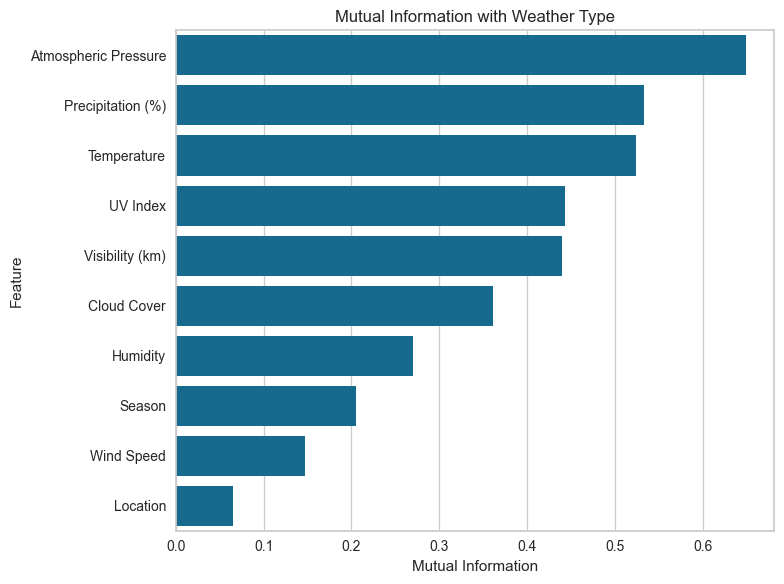

In [32]:
features = ["Temperature", "Humidity", "Wind Speed", 
            "Precipitation (%)", "Cloud Cover", 
            "Atmospheric Pressure", "UV Index", 
            "Season", "Visibility (km)", "Location"]


# Вычисляем взаимную информацию
X = df[features]
y = df['Weather Type']
mi_scores = mutual_info_classif(X, y)

# Создаем DataFrame с результатами
mi_df = pd.DataFrame({'Feature': features, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values('Mutual Information', ascending=False)

# Визуализация
plt.figure(figsize=(8, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Mutual Information with Weather Type')
plt.tight_layout()
plt.show()

### Let's try to increase the indicators by keeping the weights with the highest values. Let's remove the weights with values less than 0.2.

In [47]:
corr_features = ["Wind Speed", "Location", "Season"]

ndata_corr = ndata.drop(columns=corr_features)

ndata_corr.head()

,Temperature,Humidity,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Visibility (km),Weather Type
0,-0.294931,0.212404,0.887629,-0.666439,0.134203,-0.520104,-0.582231,Rainy
1,1.143035,1.351385,0.543291,-0.666439,0.150602,0.776424,1.345768,Cloudy
2,0.625367,-0.233285,-1.178401,-1.508095,0.346579,0.257813,0.010999,Sunny
3,1.085516,0.707613,0.887629,-1.508095,0.549008,0.776424,-1.323769,Sunny
4,0.452811,0.261924,0.386773,1.016874,-0.407490,-0.779410,-0.878846,Rainy


In [48]:
features_2 = ["Temperature", "Humidity", "Precipitation (%)",
              "Cloud Cover", "Atmospheric Pressure", "UV Index",
              "Visibility (km)"]

X_train, X_test, y_train, y_test = train_test_split(
    ndata_corr[features_2], 
    ndata_corr["Weather Type"],
    test_size=0.3,
    stratify=ndata["Weather Type"]
    )

corr_rf_model = RandomForestClassifier()
corr_rf_model.fit(X_train, y_train)
y_pred_corr = corr_rf_model.predict(X_test)
print("Random Forest model taking into account the correlation - Classification Report")
print(classification_report(y_test, y_pred_corr))
corr_accuracy = accuracy_score(y_test, y_pred_corr)
print("Accuracy:", corr_accuracy)

Random Forest with taking into account the correlation - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.88      0.90      0.89       990
       Rainy       0.90      0.90      0.90       990
       Snowy       0.95      0.92      0.93       990
       Sunny       0.92      0.93      0.93       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Accuracy: 0.9136363636363637


# Choosing the best Random Forest model

### Baseline Random Forest Model:
**Accuracy:** 0.9154  
The baseline model has a slight advantage in overall accuracy (by 0.18%).  
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.91      0.92      0.92       990
       Snowy       0.94      0.93      0.93       990
       Sunny       0.93      0.90      0.91       990

    accuracy                           0.92      3960
    macro avg       0.92      0.92     0.92      3960
    weighted avg    0.92      0.92     0.92      3960  

### Random Forest model taking into account the correlation
**Accuracy:** 0.9136363636363637
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.88      0.90      0.89       990
       Rainy       0.90      0.90      0.90       990
       Snowy       0.95      0.92      0.93       990
       Sunny       0.92      0.93      0.93       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960


## Analysis of Results

**Overall Performance:**  
- Both models demonstrate high accuracy (over 91%), indicating a good ability to classify weather types.
- The baseline model has a slight advantage in overall accuracy (by 0.18%).

**Performance by Class:**  
- Baseline Model: More balanced precision and recall for all classes.
- Model with Correlation Consideration: Slight improvement in "Sunny" classification but a slight decrease for "Cloudy" and "Rainy".

**Model Robustness:**
Both models exhibit high robustness, with minimal differences between precision, recall, and f1-score for different classes.

**Impact of Correlation Consideration:**
Considering correlation did not lead to significant model improvement. This may indicate that the baseline model already effectively utilizes the most informative features.

### Conclusion:
Best Model Choice: The baseline Random Forest model shows the best results in terms of overall accuracy and balanced performance across all classes.


# Clustering

In [55]:
X = df[features]

X_scaled = scaler.fit_transform(X)

### Elbow method

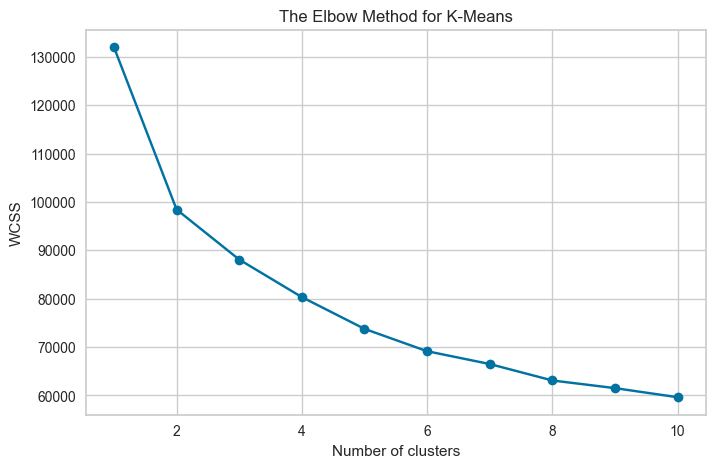

In [56]:
# Визначення кількості кластерів для тестування
k_range = range(1, 11)
wcss = []

# KMeans
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=170)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title("The Elbow Method for K-Means")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

### Yellowbrick

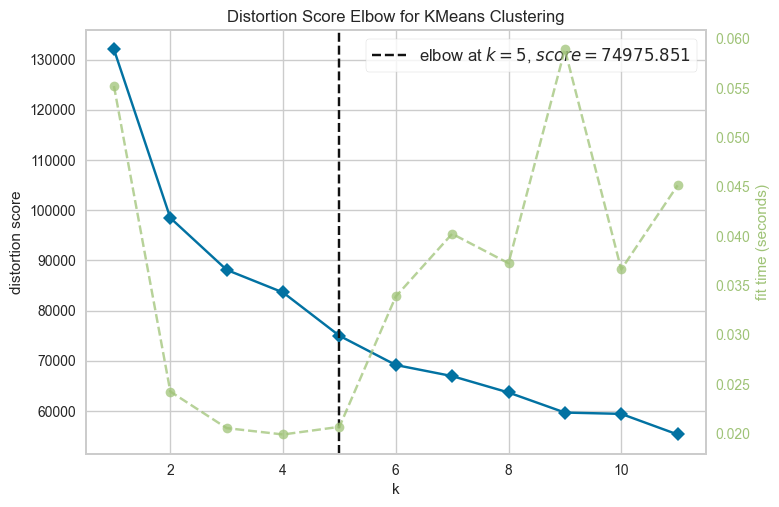

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
model = KMeans()
visualizer_1 = KElbowVisualizer(model, k=(1,12))
visualizer_1.fit(X_scaled)
visualizer_1.show()


### Silhouette method for K-Means

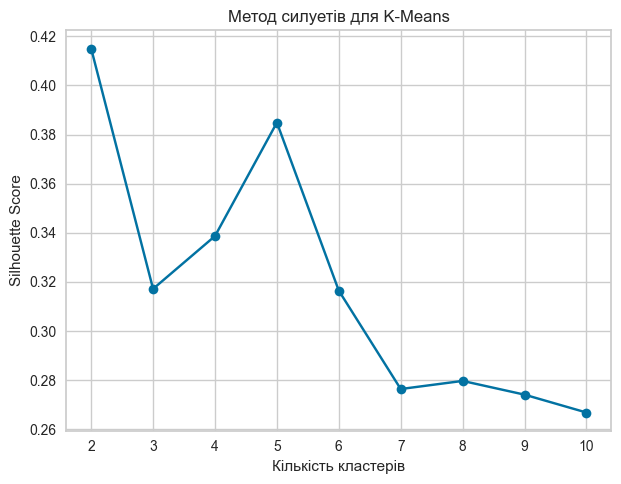

In [54]:

k_range = range(2, 11)
silhouette_scores_kmeans = []

# Обчислення silhouette_score для кожного значення k для K-Means
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=170)
    labels_kmeans = kmeans.fit_predict(X)
    score = silhouette_score(X, labels_kmeans)
    silhouette_scores_kmeans.append(score)


# Побудова графіку методу силуетів для K-Means
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores_kmeans, marker='o')
plt.title("Silhouette method for K-Means")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")


plt.tight_layout()
plt.show()

## Determining the Optimal Number of Clusters:  

The elbow method graph does not clearly indicate the number of clusters.   
Using the Yellowbrick library, you can determine 5 clusters.  
The silhouette method for K-Means also suggests 5 clusters.  

         Temperature   Humidity  Wind Speed  Precipitation (%)  Cloud Cover  \
Cluster                                                                       
0          27.428726  49.487550    5.718513          21.321184     0.800794   
1           0.365972  79.880388   10.396375          74.285470     2.598915   
2          32.385662  89.904719   21.210980          90.098911     1.608893   
3          24.204892  79.191776   12.015243          71.461538     2.301312   
4          23.718282  55.796537    6.743590          29.277722     1.353313   

         Atmospheric Pressure  UV Index    Season  Visibility (km)  Location  
Cluster                                                                       
0                 1031.423132  6.774450  1.488993         7.942079  0.424756  
1                  990.683154  1.173280  0.056523         3.133743  0.468170  
2                 1006.980817  8.939201  1.226860         4.196915  0.878403  
3                 1007.257441  1.766749  1.777384  

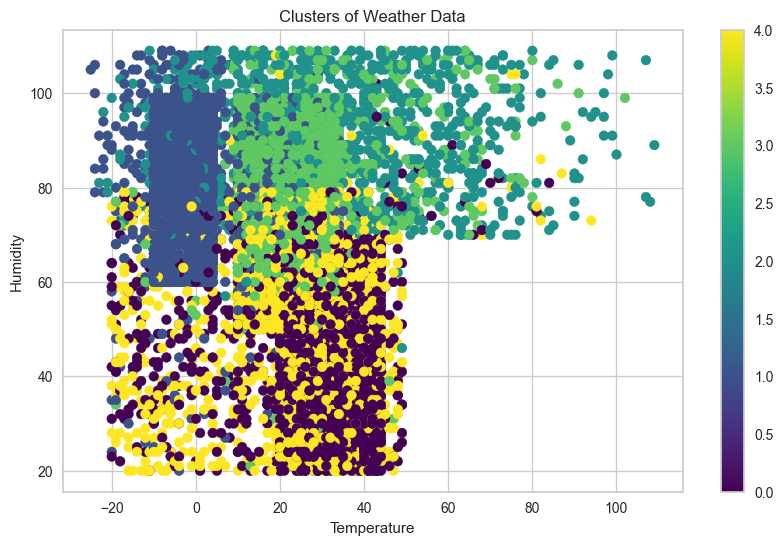

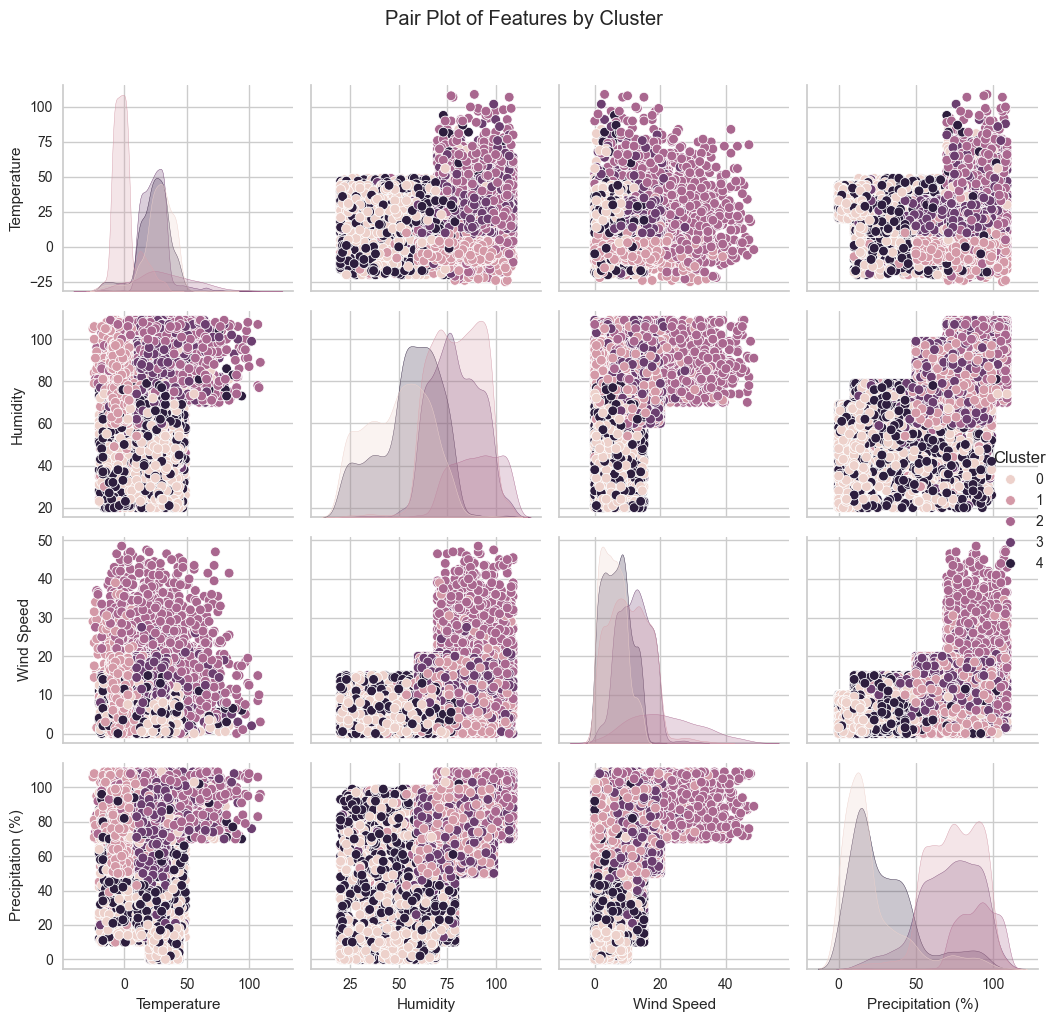

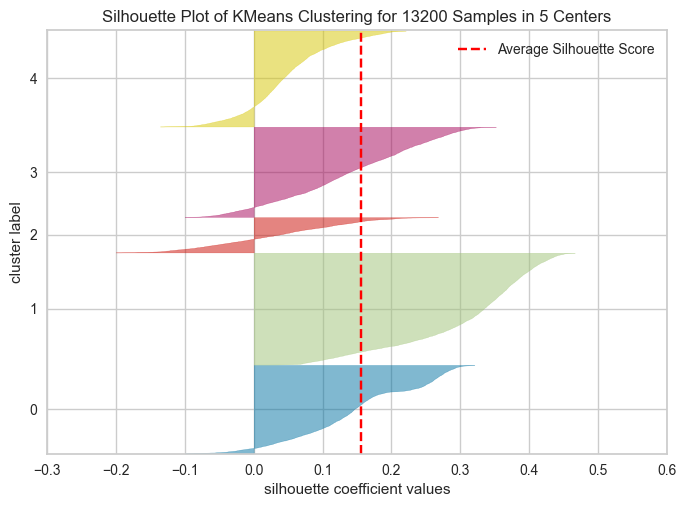

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 13200 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [57]:

from yellowbrick.cluster import SilhouetteVisualizer


# Применение K-Means с 5 кластерами
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Создание новой копии DataFrame с метками кластеров
df_clusters = df.copy()
df_clusters['Cluster'] = cluster_labels

# Анализ кластеров: Средние значения признаков для каждого кластера
cluster_means = df_clusters.groupby('Cluster')[features].mean()
print(cluster_means)

# Визуализация кластеров (пример для двух признаков)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_clusters['Temperature'], df_clusters['Humidity'], c=df_clusters['Cluster'], cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.title('Clusters of Weather Data')
plt.colorbar(scatter)
plt.show()

# Визуализация кластеров с использованием других признаков
sns.pairplot(df_clusters, hue='Cluster', vars=['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'])
plt.suptitle('Pair Plot of Features by Cluster', y=1.02)
plt.tight_layout()
plt.show()

# Визуализация кластеров с использованием Yellowbrick
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

Weather Type    Cloudy     Rainy     Snowy     Sunny
Cluster                                             
0             0.273547  0.036088  0.040419  0.649946
1             0.044248  0.131316  0.815587  0.008850
2             0.266788  0.323049  0.148820  0.261343
3             0.158809  0.788727  0.004963  0.047501
4             0.547786  0.052947  0.050949  0.348318


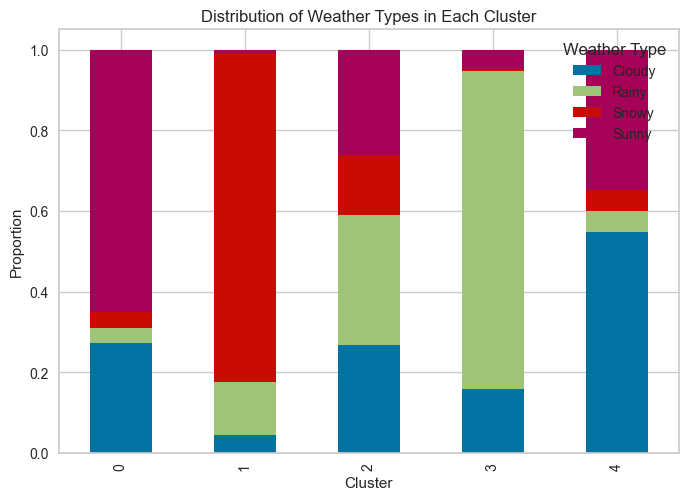

In [64]:
weather_cluster_distribution = pd.crosstab(df_clusters['Cluster'], df_clusters['Weather Type'], normalize='index')
print(weather_cluster_distribution)

weather_cluster_distribution.plot(kind='bar', stacked=True)
plt.title('Distribution of Weather Types in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Weather Type')
plt.show()

In [68]:
# Добавление кластера как нового признака
X_with_clusters = df_clusters[features + ['Cluster']]
X_with_clusters = scaler.fit_transform(X_with_clusters)

y = df_clusters['Weather Type']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.3, random_state=42)

# Обучение модели Random Forest с новым признаком
clust_model = RandomForestClassifier(random_state=42)
clust_model.fit(X_train, y_train)
y_pred_clust = clust_model.predict(X_test)
print("Random Forest with Clustering - Classification Report")
print(classification_report(y_test, y_pred_clust))
clust_accuracy = accuracy_score(y_test, y_pred_clust)
print("Accuracy:", clust_accuracy)

Random Forest with Clustering - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.88       955
       Rainy       0.90      0.91      0.91       982
       Snowy       0.94      0.94      0.94      1033
       Sunny       0.94      0.90      0.92       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Accuracy: 0.9133838383838384


In [62]:
misclassified = X_test[y_test != y_pred_clust]
misclassified['True_Weather'] = y_test[y_test != y_pred_clust]
misclassified['Predicted_Weather'] = y_pred_clust[y_test != y_pred_clust]
print(misclassified.groupby(['Cluster', 'True_Weather', 'Predicted_Weather']).size().unstack(fill_value=0))

Predicted_Weather     Cloudy  Rainy  Snowy  Sunny
Cluster True_Weather                             
0       Cloudy             0      6      9      9
        Rainy             14      0     10      8
        Snowy             16      4      0      3
        Sunny             13      7     11      0
1       Cloudy             0      2      3      2
        Rainy              1      0      2      1
        Snowy              0      1      0      2
        Sunny              4      1      4      0
2       Cloudy             0     18      0      1
        Rainy             14      0      0      0
        Snowy              2      0      0      0
        Sunny              6      2      1      0
3       Cloudy             0     15      0      1
        Rainy              6      0      0      0
        Snowy              2      0      0      1
        Sunny              9      4      1      0
4       Cloudy             0     13      8     10
        Rainy             13      0      6     10


/var/folders/zb/nl25s0l50sl0r6n18b3fm3w00000gp/T/ipykernel_77735/3308851557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['True_Weather'] = y_test[y_test != y_pred_clust]
/var/folders/zb/nl25s0l50sl0r6n18b3fm3w00000gp/T/ipykernel_77735/3308851557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['Predicted_Weather'] = y_pred_clust[y_test != y_pred_clust]


# Results

### Baseline Random Forest Model:
**Accuracy:** 0.9154
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.91      0.92      0.92       990
       Snowy       0.94      0.93      0.93       990
       Sunny       0.93      0.90      0.91       990

    accuracy                           0.92      3960
    macro avg       0.92      0.92     0.92      3960
    weighted avg    0.92      0.92     0.92      3960 


### GridSearchCV Optimized Random Forest Model:
**Accuracy:** 0.9146 
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.89      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.95      0.93      0.94       990
       Sunny       0.92      0.90      0.91       990

    accuracy                           0.91      3960
   macro avg       0.92      0.91      0.91      3960
weighted avg       0.92      0.91      0.91      3960


### RandomizedSearchCV Optimized Random Forest Model:
**Accuracy:** 0.9144 
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.90      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.95      0.93      0.94       990
       Sunny       0.91      0.91      0.91       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960


### Random Forest model taking into account the correlation
**Accuracy:** 0.9136363636363637
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.88      0.90      0.89       990
       Rainy       0.90      0.90      0.90       990
       Snowy       0.95      0.92      0.93       990
       Sunny       0.92      0.93      0.93       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960


### Random Forest with Clustering 
**Accuracy:** 0.9133838383838384
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.88       955
       Rainy       0.90      0.91      0.91       982
       Snowy       0.94      0.94      0.94      1033
       Sunny       0.94      0.90      0.92       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960



# Conclusion  

Based on the results, the following observations can be made:

- **Overall Performance:**

    - All models demonstrate high accuracy (around 91%), indicating a good ability to classify different weather types.

- **Baseline Random Forest Model:**

    - Accuracy: 0.9154
    - The baseline model shows slightly higher overall accuracy compared to the optimized and correlation-based models.

- **Optimized Random Forest Models:**

    - **GridSearchCV Optimized Model:**
        - Accuracy: 0.9146
        - Shows slight improvement in precision for "Snowy" but similar performance to the baseline for other classes.

    - **RandomizedSearchCV Optimized Model:**
        - Accuracy: 0.9144
        - Similar performance to the GridSearchCV optimized model, with balanced precision and recall across all classes.

- **Random Forest Model with Correlation Consideration:**

    - Accuracy: 0.9136
    - Exhibits a slight decrease in overall accuracy compared to the baseline. Shows improvement in recall for "Sunny" but a slight drop for "Cloudy".

- **Random Forest Model with Clustering:**

    - Accuracy: 0.9134
    - Similar performance to the correlation-based model. Notably, it has the highest precision for the "Sunny" class but lower precision for "Cloudy".

## Best Model Choice:


The Baseline Random Forest Model shows the best results in terms of overall accuracy and balanced performance across all classes. While the optimized models and those considering correlation or clustering provide competitive results, they do not offer significant improvements over the baseline model. Therefore, the baseline model is recommended for its slightly superior accuracy and consistent performance.